In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# File Paths

In [ ]:
model_path = "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/AE-MLP Model Files/Models"
dataset_path =  "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/AE-MLP Model Files/Datasets and Numpy Arrays"

#Imports

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#Loads Datasets
(and convert them to numpy arrays)

In [ ]:
# Training sets
X_train = pd.read_csv(os.path.join(dataset_path, "ae_x_train.csv")).to_numpy()
y_train = pd.read_csv(os.path.join(dataset_path, "ae_y_train.csv")).to_numpy().ravel()

# Validation sets
X_val = pd.read_csv(os.path.join(dataset_path, "ae_x_val.csv")).to_numpy()
y_val = pd.read_csv(os.path.join(dataset_path, "ae_y_val.csv")).to_numpy().ravel()

# # Classifier training sets
X_classifier_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_x_train.csv")).to_numpy() # MLP training data augumented using adasyn
y_classifier_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_y_train.csv")).to_numpy().ravel()

# Classifier validation sets
X_classifier_val = pd.read_csv(os.path.join(dataset_path, "mlp_x_val.csv")).to_numpy()
y_classifier_val = pd.read_csv(os.path.join(dataset_path, "mlp_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_x_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_y_test.csv")).to_numpy().ravel()

# Label Encoding
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label



#Remove Class Function

In [ ]:
def Remove_attack_type(attack_type):
    global X_classifier_train, y_classifier_train, X_classifier_val, y_classifier_val

    # Filter classifier training sets
    mask_classifier_train = (y_classifier_train != attack_type)  # Create a new array, mask_classifier_train (same shape as y_classifier_train), where values are added if the corresponding value in y_classifier_train is not equal to attack_type
    X_classifier_train_filtered = X_classifier_train[mask_classifier_train]
    y_classifier_train_filtered = y_classifier_train[mask_classifier_train]

    # Filter classifier validation sets
    mask_classifier_val = (y_classifier_val != attack_type) # Create a new array, mask_classifier_val (same shape as y_classifier_val), where values are added if the corresponding value in y_classifier_val is not equal to attack_type
    X_classifier_val_filtered = X_classifier_val[mask_classifier_val]
    y_classifier_val_filtered = y_classifier_val[mask_classifier_val]

    return X_classifier_train_filtered, y_classifier_train_filtered, X_classifier_val_filtered, y_classifier_val_filtered # Return the filtered sets



#Import AE

In [ ]:
def get_ae():
  # -------------------------
  # --- Load AE Model ---
  # -------------------------
  ae_model_path = os.path.join(model_path, 'Best_AE.keras') # Get path name
  ae_model = load_model(ae_model_path) # Load model

  # -----------------------------------
  # --- Load Per-Feature Thresholds ---
  # -----------------------------------
  per_feature_thresholds_path = os.path.join(dataset_path, 'ae_per_feature_thresholds.npy') # Get path name
  per_feature_thresholds = np.load(per_feature_thresholds_path) # Load model

  return ae_model, per_feature_thresholds # Return the AE model and its premade threshold array from the FP32 AE code


# Build MLP Model Function

In [ ]:
def build_mlp():
  global X_classifier_train, y_classifier_train
  # Input dimensions
  input_dim = X_classifier_train.shape[1]  # Input shape is just the number of features in the data (52)
  num_classes = len(np.unique(y_classifier_train))

  classifier = Sequential([
        Input(shape=(input_dim,)), # Input layer
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),# Hidden layer (L2 for regularisation to prevent any overfitting)
        Dense(32, activation='relu',kernel_regularizer=l2(0.001)), # Hidden layer
        Dropout(0.2), # Dropout layer (reset 20% of the model's neurons to zero to prevent overfitting)
        Dense(num_classes, activation='softmax')# Output layer (ouputs a vector of 7 values, one for each class, where each value is a probability that a sample belongs to a specific class)
    ])

  # Compile the model
  classifier.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  print(classifier.summary())

  return classifier # Return the model that was built

# Train the MLP model Function

In [ ]:
def train_mlp(classifier, new_X_classifier_train, new_y_classifier_train,new_X_classifier_val, new_y_classifier_val): # Train the model

  # Early-stopping
  early_stopping = EarlyStopping(monitor='val_loss',      # Specify monitor='val_loss' to track the validation loss.
                               patience=4,                # The number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

  # Train the model
  history = classifier.fit(
      new_X_classifier_train, new_y_classifier_train,
      epochs=20,
      batch_size=64,
      validation_data=(new_X_classifier_val, new_y_classifier_val),
      verbose=1,
      callbacks=[early_stopping], # Add early stopping callback
  )

  # --- Plot history accuracy and loss graphs ---
  plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Acc')
  plt.plot(history.history['val_accuracy'], label='Val Acc')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()



  return classifier # Return the trained classifier

# Test the models on the test dataset

In [ ]:
def test_models(autoencoder, per_feature_thresholds, classifier): # Test AE and MLP models
  global X_test, y_test

  test_reconstructions = autoencoder.predict(X_test, verbose=1)# Run autoencoder on the entire test set at once

  test_reconstruction_errors = np.abs(test_reconstructions - X_test)# Compute test reconstruction errors for all samples

  AE_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)# Flag anomalies (samples with ANY feature above its threshold per sample) and broadcast thresholds across all samples

  malicious_pred_indices = np.flatnonzero(AE_y_pred)# Find the indices of all non-zero elements in AE_y_pred (samples predicted as Malicious by the AE)

  # Run classifier only on anomalous samples (if any)
  classifier_y_pred_probs, classifier_y_preds, classifier_y_test, classifier_x_test = [], [], [], []

  if len(malicious_pred_indices) > 0:
      # Get the samples and true label values of the samples deemed as malware by the AE that the MLP will classify
      classifier_y_test = y_test[malicious_pred_indices]
      classifier_x_test = X_test[malicious_pred_indices]

      classifier_y_pred_probs = classifier.predict(classifier_x_test, verbose=1) # predict samples' class
      classifier_y_preds = np.argmax(classifier_y_pred_probs, axis=1)# Final mlp sample class predictions

  return AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test # Return the AE and MLP sample class predicitions and the mlp's filtered test sets



# Evaluate AE Predictions Against Ground Truths

In [ ]:
def evaluate_ae(AE_y_pred, unseen_attack):
  global y_test

  reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
  unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

  y_test_binary = (y_test != 0).astype(int)# Convert y_test to binary to evaluate AE predictions (0 = Normal, 1 = Anomaly)

  # --- Confusion matrix ---
  ae_cm = confusion_matrix(y_test_binary, AE_y_pred) # Compute confusion matrix
  ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel() # Unpack confusion matrix values

  # Plot heatmap
  plt.figure(figsize=(4, 2)) # Adjust figure size
  binary_labels = ['Benign', 'Anomaly']# Labels for the binary confusion matrix
  sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
  plt.title("AE Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # Get Performance and detection metrics
  print("\nAE Metrics:")
  print(f"True Positives (Anomalies correctly detected): {ae_tp}")
  print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
  print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
  print(f"False Negatives (Anomalies missed): {ae_fn}\n")
  accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
  precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
  recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
  f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
  false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
  print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

  # --- Calc how many unseen attacks were detected ---
  unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]# Get indices of unseen atack samples in the original test set
  mal_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 1)# Count how many were predicted as malicious by the AE
  benign_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 0)# Count how many were predicted as benign by the AE
  print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
  print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")


# Evaluate MLP Classifier Predictions

In [ ]:
def evaluate_classifier(classifier_y_test, classifier_y_preds, unseen_attack):

    # --- Confusion matrix ---
    mlp_cm = confusion_matrix(classifier_y_test, classifier_y_preds)

    # Get the original attack type names from the mapping
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])] # Use matrix shape for label count
    unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

    # Plot heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Classifier Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(mlp_cm[normal_traffic, :])
        benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        mlp_tn = benign_identified_correctly
        mlp_fp = benign_misclassified

        total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])

        malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        mlp_fn = malware_misclassified
        mlp_tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
        print("\nTP, TN, FP, FN for Malware vs Benign:")
        print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = mlp_cm[i, i]
                total_in_class = np.sum(mlp_cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Performance Metrics ---
        # Accuracy
        accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
        # Precision (for malware class)
        precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


        unseen_attack_test_indices = np.where(classifier_y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == unseen_attack) # Gives zero
        benign_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#Quant Models

In [ ]:
import tensorflow as tf

def mlp_representative_dataset_gen(y_classifier_train, X_classifier_train):
    # Get class distribution
    class_types, class_counts = np.unique(y_classifier_train, return_counts=True)
    min_samples_per_class = min(class_counts)

    class_indices = [np.where(y_classifier_train == c)[0] for c in class_types]

    # Pick equal number of samples per class (eg: 100 per class)
    selected_indices = []
    rng = np.random.default_rng(seed=123) # Random seed for reproducability of sample selection
    for indices in class_indices:
        selected_indices.extend(rng.choice(indices, 100, replace=False))

    np.random.shuffle(selected_indices)
    representative_indices = selected_indices

    # Yield samples reshaped for MLP: (1, number of features) as a quant model expects a batch size of 1
    for i in representative_indices:
        yield [np.expand_dims(X_classifier_train[i].astype(np.float32), axis=0)]


def quant_models(autoencoder, classifier, y_classifier_train, X_classifier_train):
    # --- Load AE Quant Models (with TFLite Interpreter) ---
    ae_model_base = os.path.join(model_path,'Best_AE')
    # load the quantised Autoencoder (AE) models into TensorFlow Lite interpreters
    ae_quantModel_f32 = tf.lite.Interpreter(model_path=ae_model_base + '_float32.tflite')
    ae_quantModel_int8_weights = tf.lite.Interpreter(model_path=ae_model_base + '_int8_weights.tflite')
    ae_quantModel_fp16_weights = tf.lite.Interpreter(model_path=ae_model_base + '_fp16_weights.tflite')
    ae_quantModel_full_int8 = tf.lite.Interpreter(model_path=ae_model_base + '_int8_full.tflite')

    # QUANT MLPS
    # --- Float32 baseline (no quantization) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    print("# --- MLP Float32 baseline (no quantization) ---")
    mlp_quantModel_f32 = converter.convert() # Convert model
    mlp_quantModel_f32 = tf.lite.Interpreter(model_content=mlp_quantModel_f32)# Load the tflite fp32 mlp model into a TensorFlow Lite interpreter

    # --- Weight-only quantization (float16 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    print("# --- MLP Weight-only quantization (float16 weights, float32 activations) ---")
    mlp_quantModel_fp16_weights = converter.convert() # Convert model
    mlp_quantModel_fp16_weights = tf.lite.Interpreter(model_content=mlp_quantModel_fp16_weights)# Load the quantised mlp model into a TensorFlow Lite interpreter

    # --- Weight-only quantization (int8 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    print("# --- MLP Weight-only quantization (int8 weights, float32 activations) ---")
    mlp_quantModel_int8_weights = converter.convert() # Convert model
    mlp_quantModel_int8_weights = tf.lite.Interpreter(model_content=mlp_quantModel_int8_weights)# Load the quantised mlp model into a TensorFlow Lite interpreter

    # --- MLP Full 8-bit Integer Quantization ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: mlp_representative_dataset_gen(y_classifier_train, X_classifier_train) # lambda function that returns the representative data generator function
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8 # Establish what data type the model's input and output samples should be in (int8 format)
    converter.inference_output_type = tf.int8
    print("# --- MLP Full 8-bit Integer Quantization ---")
    mlp_quantModel_full_int8 = converter.convert() # Convert model
    mlp_quantModel_full_int8 = tf.lite.Interpreter(model_content=mlp_quantModel_full_int8)# Load the quantised mlp model into a TensorFlow Lite interpreter

    print("Quant Models Ready!")

    return (
        ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8,
        mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8
    ) # Return the quantised models that have already been loaded into interpreters


#Evaluate Quant Models

Evaluate FP32, FP16 and Dynamic INT8 TFlite Models

In [ ]:
def evaluate_weight_quant_model(tflite_weight_models, per_feature_thresholds, unseen_attack):
    global X_test, y_test

    for m in tflite_weight_models:# Loop through all the models
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n --- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------------
        # --- Autoencoder ---
        # -------------------

        # Set up the AE tflite model
        ae_interpreter = ae_model_content # Because the intepreter was already loaded in quant_models()
        ae_interpreter.allocate_tensors() # Make the interpreter allocate memory
        ae_input_details = ae_interpreter.get_input_details()   # Get expected shape and data type of the data the model needs to evaluate (built-in method)
        ae_output_details = ae_interpreter.get_output_details() # Get the shape and data type the model will need to produce the results in

        # Get AE predictions
        ae_y_pred_probs = []
        for i in range(len(X_test)):
            input_data = np.expand_dims(X_test[i], axis=0).astype(ae_input_details[0]['dtype']) # Shape input datat fro tflite model
            ae_interpreter.set_tensor(ae_input_details[0]['index'], input_data) # Feed a single sample of input data into the TFLite interpreter
            ae_interpreter.invoke() # Tell the interpreter to run the model on the input data
            ae_output_data = ae_interpreter.get_tensor(ae_output_details[0]['index']) # Get the output from the model
            ae_y_pred_probs.append(ae_output_data[0]) # Add output to the predictions list

        ae_y_pred_probs = np.array(ae_y_pred_probs) # Turn the output list into a numpy array
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test) # Get reconstruction errors of test set data
        ae_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int) # Get final binary predicition of samples' class (0 for bening or 1 for malicious)

        malicious_pred_indices = np.flatnonzero(ae_y_pred) # Get indices of test samples that teh AE predicted as malicious

        # Confusion matrix for AE
        y_test_binary = (y_test != 0).astype(int) # Change the y_test labels to binary for the AE's prediction evaluation
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred) # Get AE confusion matrix

        # Plot heatmap
        plt.figure(figsize=(6, 4))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Malware"], yticklabels=["Normal", "Malware"])
        plt.title(f"{ae_name} - Confusion Matrix (Anomaly Detection)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel() # Get values from AE confusion matrix

        # Print Quant AE performance metrics
        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")

        accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
        precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
        recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
        false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
        print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

        # Print the number of unseen attacks detected by the quant AE
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -----------
        # --- MLP ---
        # -----------

        # Set up MLP tflite model
        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()
        mlp_output_details = mlp_interpreter.get_output_details()

        # Get MLP predictions
        mlp_y_pred_probs = []
        # Get the samples predicted as malicious by the AE as well as their true labels (for evaluation)
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)): # Loop through the samples
            input_data = np.expand_dims(mlp_X_test[i], axis=0).astype(mlp_input_details[0]['dtype']) # Reshape input sample for model and change its data type
            mlp_interpreter.set_tensor(mlp_input_details[0]['index'], input_data)
            mlp_interpreter.invoke()
            mlp_output_data = mlp_interpreter.get_tensor(mlp_output_details[0]['index'])
            mlp_y_pred_probs.append(mlp_output_data[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs)# Change output prediction list to a numpy array
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1) # get final MLP predictions

        # Confusion matrix for MLP
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred) # Compute mlp confusion matrix
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]
        # Plot heatmap
        plt.figure(figsize=(7, 4))
        sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Classifier Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        normal_traffic = attack_type_map.get('Normal Traffic', None)
        if normal_traffic is not None:

            total_benign = np.sum(mlp_cm[normal_traffic, :])
            benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            mlp_tn = benign_identified_correctly
            mlp_fp = benign_misclassified

            total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])

            malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

            # Count all the malware samples identified even if misclassified as the wrong type of malware
            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # skip the normal traffic row in the cm
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            mlp_fn = malware_misclassified
            mlp_tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
            print("\nTP, TN, FP, FN for Malware vs Benign:")
            print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = mlp_cm[i, i]
                    total_in_class = np.sum(mlp_cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            # Accuracy
            accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
            # Precision (for malware class)
            precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack)
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)

            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


Evaluate Full INT8 AE-MLP Models

In [ ]:
def evaluate_full_int8_quant_model(tflite_full_int_models, unseen_attack):
    global X_test, y_test

    for m in tflite_full_int_models:
        # --- Unpack model info ---
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n--- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------
        # ---- AE -----
        # -------------

        # Set up the AE tflite model
        ae_interpreter = ae_model_content # Because the intepreter was already loaded in quant_models()
        ae_interpreter.allocate_tensors() # Make the interpreter allocate memory
        ae_input_details = ae_interpreter.get_input_details()   # Get expected shape and data type of the data the model needs to evaluate (built-in method)
        ae_output_details = ae_interpreter.get_output_details() # Get the shape and data type the model will need to produce the results in

        # Get scaling and zero point values for quantisation and dequantisation of samples
        in_scale,  in_zp  = ae_input_details['quantization']
        out_scale, out_zp = ae_output_details['quantization']

        # Load int8 threshold for the model
        full_int8_per_feature_thresholds_path = os.path.join(dataset_path,'FULL_INT8_per_feature_Threshold.npy') # Get path name
        full_int8_per_feature_thresholds = np.load(full_int8_per_feature_thresholds_path)

        # --- AE Predictions ---
        ae_y_pred_probs = []
        for i in range(len(X_test)):# Loop through test sample set
          input_sample = np.expand_dims(X_test[i].astype(np.float32), axis=0)  # Reshape input to be (1, num_features)
          if ae_input_details['dtype'] == np.int8:
              quant_input_sample = np.round(input_sample / in_scale + in_zp).astype(np.int8) # Quantise an input sample

          # give the input to INT8 AE model to process
          ae_interpreter.set_tensor(ae_input_details['index'], quant_input_sample)
          ae_interpreter.invoke()
          quant_ouput = ae_interpreter.get_tensor(ae_output_details['index']) # get AE's output

          if ae_output_details['dtype'] == np.int8:
              ouput = (quant_ouput.astype(np.float32) - out_zp) * out_scale # Dequantise the output

          ae_y_pred_probs.append(ouput[0]) # get list of reconstructed samples

        ae_y_pred_probs = np.array(ae_y_pred_probs) # Turn list into an array

        # --- Anomaly Detection ---
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test) # Get test reconstruction erors
        ae_y_pred = (test_reconstruction_errors > full_int8_per_feature_thresholds).any(axis=1).astype(int) # Compare test errors to the int8 threshold values
        malicious_pred_indices = np.flatnonzero(ae_y_pred) # get indices of samples predicted as malicious by the AE

        # --- Confusion Matrix (AE) ---
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        y_test_binary = (y_test != 0).astype(int)  # Convert y_test to binary: 0 = Normal, 1 = Anomaly for AE confusion matrix
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred) # Compute AE confusion matrix
        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel() # Get AE's cm values

        # Plot heatmap
        plt.figure(figsize=(4, 2))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Anomaly'], yticklabels=['Benign', 'Anomaly'])
        plt.title("AE Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Get the Full INT8 AE's performance metrics
        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")
        accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
        precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
        recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
        false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
        print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

        # Get the amount of unseen attacks detected by the Full INT8 AE
        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)
        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -------------
        # --- MLP -----
        # -------------
        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()[0]
        mlp_output_details = mlp_interpreter.get_output_details()[0]

        mlp_in_scale, mlp_in_zp = mlp_input_details['quantization']
        mlp_out_scale, mlp_out_zp = mlp_output_details['quantization']

        # --- MLP Predictions ---
        mlp_y_pred_probs = []

        # Get the test samples the AE predicted as malicious as well as their true labels
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)):
            input_sample = np.expand_dims(mlp_X_test[i].astype(np.float32), axis=0)
            if mlp_input_details['dtype'] == np.int8:
                quant_input_sample = np.round(input_sample / mlp_in_scale + mlp_in_zp).astype(np.int8) # Quantise the Full int8 MLP's input sample

            mlp_interpreter.set_tensor(mlp_input_details['index'], quant_input_sample)
            mlp_interpreter.invoke()
            quant_output = mlp_interpreter.get_tensor(mlp_output_details['index'])

            if mlp_output_details['dtype'] == np.int8:
                output = (quant_output.astype(np.float32) - mlp_out_zp) * mlp_out_scale # Dequantise the Full int8 MLP's ouput

            mlp_y_pred_probs.append(output[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs) # Turn the MLP's output into a numpy array
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1) # Get final predictions of the samples' class

        # --- Confusion Matrix (MLP) ---
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred) # Compute the MLP's confusion matrix
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]

        # Plot heatmap
        plt.figure(figsize=(7, 4))
        sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Classifier Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Get MLP's performance metrics
        normal_traffic = attack_type_map.get('Normal Traffic', None)
        if normal_traffic is not None:

            total_benign = np.sum(mlp_cm[normal_traffic, :])
            benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            mlp_tn = benign_identified_correctly
            mlp_fp = benign_misclassified

            total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])
            malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

            # Count all the malware samples identified even if misclassified as the wrong type of malware
            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # skip the normal traffic row in the cm
                    # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            mlp_fn = malware_misclassified
            mlp_tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
            print("\nTP, TN, FP, FN for Malware vs Benign:")
            print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = mlp_cm[i, i]
                    total_in_class = np.sum(mlp_cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            # Accuracy
            accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
            # Precision (for malware class)
            precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

            # get the number of unseen attacks missed and detected
            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack) # Will be zero
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)
            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#REMOVING BOTS

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703 (22.28 KB)

 Trainable params: 5,703 (22.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.7608 - loss: 0.7610 - val_accuracy: 0.9279 - val_loss: 0.3240
Epoch 2/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.8618 - loss: 0.4896 - val_accuracy: 0.9383 - val_loss: 0.2805
Epoch 3/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.8969 - loss: 0.4099 - val_accuracy: 0.9448 - val_loss: 0.3023
Epoch 4/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9380 - loss: 0.3523 - val_accuracy: 0.9601 - val_loss: 0.2583
Epoch 5/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9527 - loss: 0.3151 - val_accuracy: 0.9657 - val_loss: 0.2395
Epoch 6/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9593 - loss: 0.2881 - val_accuracy: 0.9657 - val_loss: 0.2290
Epoch 7/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9610 - loss: 0.2722 - val_accuracy: 0.9655 - val_loss: 0.2386
Epoch 8/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accur

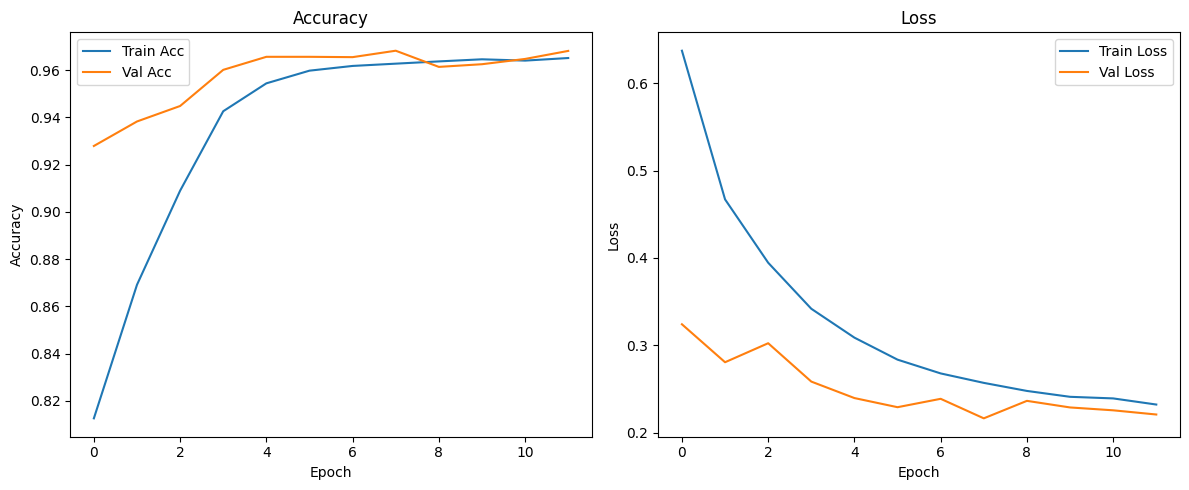

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


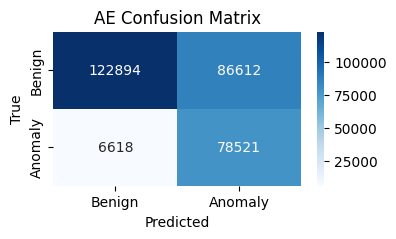


AE Metrics:
True Positives (Anomalies correctly detected): 78521
True Negatives (Normal Traffic correctly identified): 122894
False Positives (Normal Traffic misclassified as Anomaly): 86612
False Negatives (Anomalies missed): 6618

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9223
F1 Score: 0.6275
False Positive Rate (FPR): 0.4134
False Negative Rate (FNR): 0.0777
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


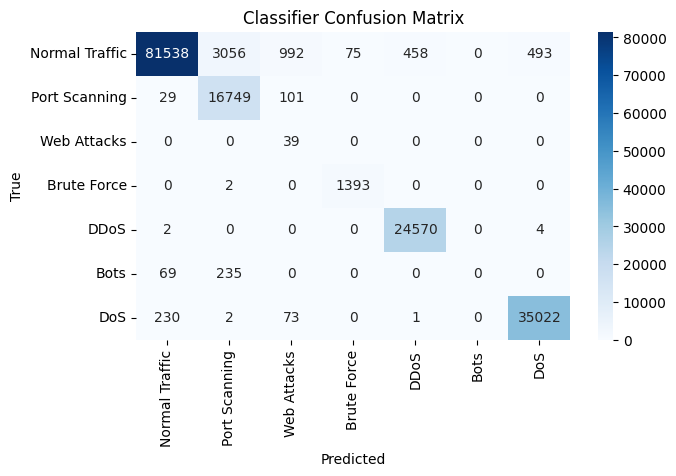

Total Malware Samples: 78521
Total Benign Samples: 86612

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78191 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81538 (94.14% of Benign Identified)
False Positives (Benign predicted as Malware): 5074 (5.86% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 99.86%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9673
Precision (Malware): 0.9391
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9666
False Positive Rate (Benign misclassified): 5.86%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69


In [ ]:
# Removing DoS
bots_encoding = 5

# --- Get filtered datasets ---
X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots = Remove_attack_type(bots_encoding)

# --- Get Autoencoder + the per feature thresholds ---
autoencoder, per_feature_thresholds = get_ae()

# --- Get the MLP ---
classifier = build_mlp()

# --- Train the MLP on the new datasets ---
classifier = train_mlp(classifier, X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots)

# --- Test the models ---
AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test = test_models(autoencoder, per_feature_thresholds, classifier)


# --- AE Evaluation ---
evaluate_ae(AE_y_pred,bots_encoding)


# --- Classifier Evaluation ---
evaluate_classifier(classifier_y_test, classifier_y_preds, bots_encoding)


# --- MLP Float32 baseline (no quantization) ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Saved artifact at '/tmp/tmp3m_7ko3c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)
# --- MLP Weight-only quantization (float16 weights, float32 activations) ---
Saved artifact at '/tmp/tmp_yekx67h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(sh

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Weight-only quantization (int8 weights, float32 activations) ---
Saved artifact at '/tmp/tmptfdt1rqz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Full 8-bit Integer Quantization ---
Saved artifact at '/tmp/tmpez0zsmjh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quant Models Ready!

 --- Evaluating AE: AE Float32 Model → MLP: MLP Float32 Model ---


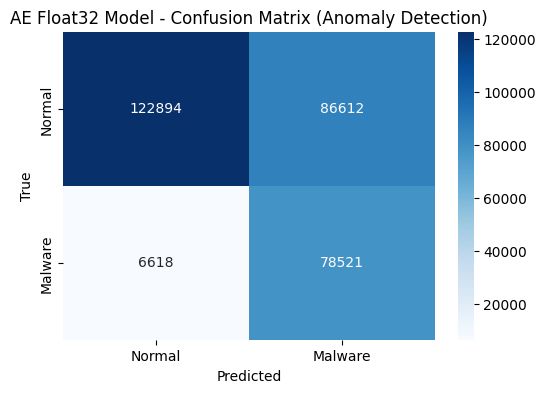


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78521
True Negatives (Normal Traffic correctly identified): 122894
False Positives (Normal Traffic misclassified as Anomaly): 86612
False Negatives (Anomalies missed): 6618

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9223
F1 Score: 0.6275
False Positive Rate (FPR): 0.4134
False Negative Rate (FNR): 0.0777
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


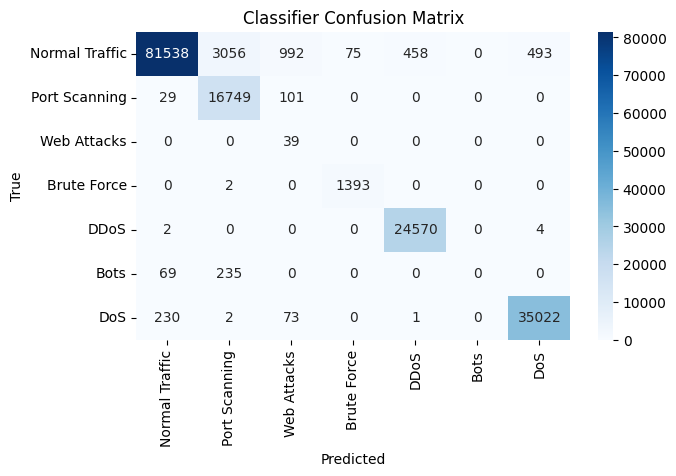

Total Malware Samples: 78521
Total Benign Samples: 86612

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78191 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81538 (94.14% of Benign Identified)
False Positives (Benign predicted as Malware): 5074 (5.86% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 99.86%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9673
Precision (Malware): 0.9391
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9666
False Positive Rate (Benign misclassified): 5.86%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69

 --- Evaluating AE: AE Float16 Wei

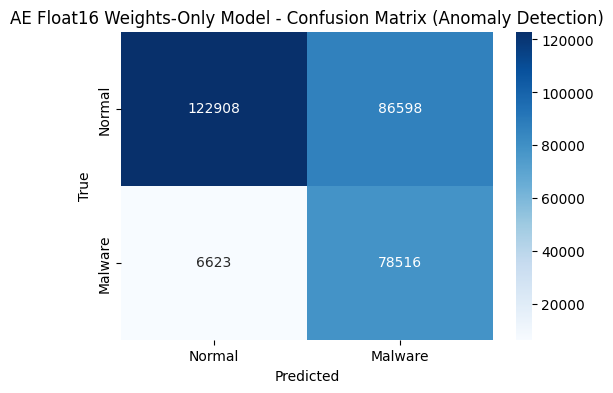


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78516
True Negatives (Normal Traffic correctly identified): 122908
False Positives (Normal Traffic misclassified as Anomaly): 86598
False Negatives (Anomalies missed): 6623

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9222
F1 Score: 0.6275
False Positive Rate (FPR): 0.4133
False Negative Rate (FNR): 0.0778
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


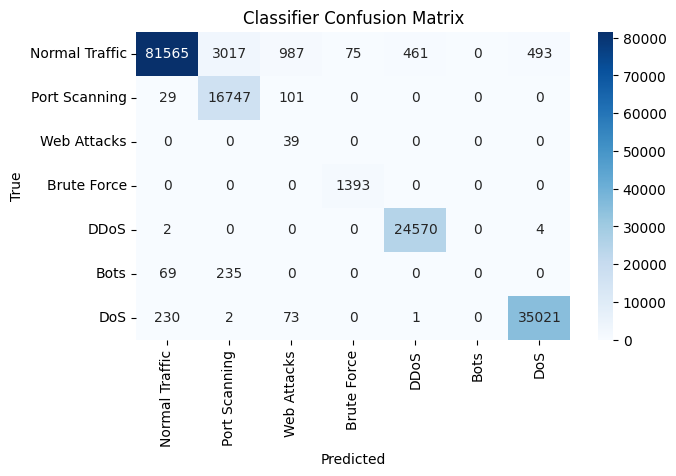

Total Malware Samples: 78516
Total Benign Samples: 86598

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78186 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81565 (94.19% of Benign Identified)
False Positives (Benign predicted as Malware): 5033 (5.81% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 100.00%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9675
Precision (Malware): 0.9395
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9668
False Positive Rate (Benign misclassified): 5.81%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69

 --- Evaluating AE: AE Int8 Weigh

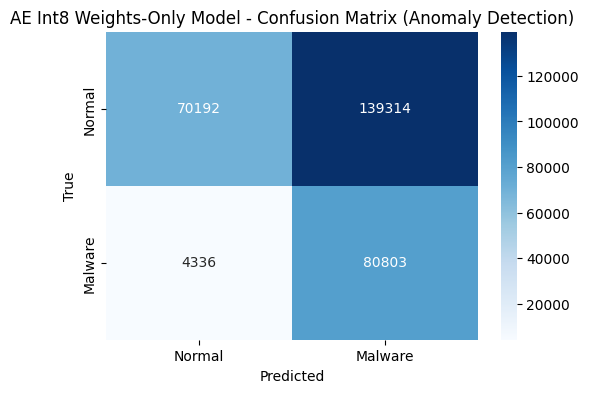


Quant AE Metrics:
True Positives (Anomalies correctly detected): 80803
True Negatives (Normal Traffic correctly identified): 70192
False Positives (Normal Traffic misclassified as Anomaly): 139314
False Negatives (Anomalies missed): 4336

Accuracy: 0.5125
Precision: 0.3671
Recall: 0.9491
F1 Score: 0.5294
False Positive Rate (FPR): 0.6650
False Negative Rate (FNR): 0.0509
Total number of Bots samples classified as malicious by AE: 371
Total number of Bots samples classified as benign by AE: 18


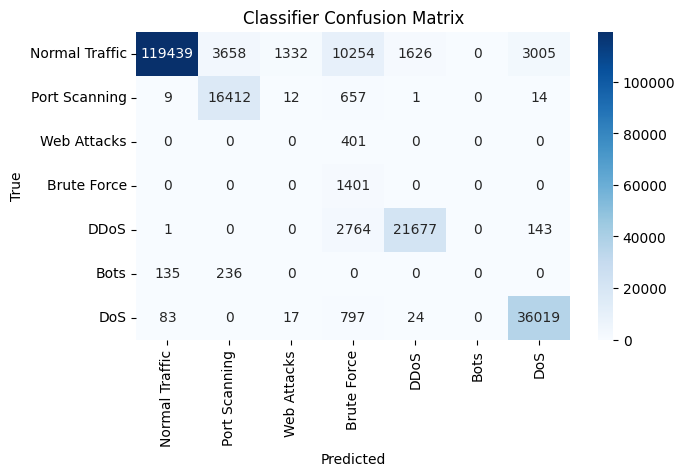

Total Malware Samples: 80803
Total Benign Samples: 139314

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 80575 (99.72% of Malware Identified)
True Negatives (Benign predicted as Benign): 119439 (85.73% of Benign Identified)
False Positives (Benign predicted as Malware): 19875 (14.27% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 228 (0.28% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 95.95%
Web Attacks: 0.00%
Brute Force: 100.00%
DDoS: 88.17%
Bots: 0.00%
DoS: 97.51%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9087
Precision (Malware): 0.8021
Recall / Sensitivity (Malware): 0.9972
F1-Score (Malware): 0.8891
False Positive Rate (Benign misclassified): 14.27%
False Negative Rate (Malware missed): 0.28%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 135

--- Evaluating AE: AE Full In

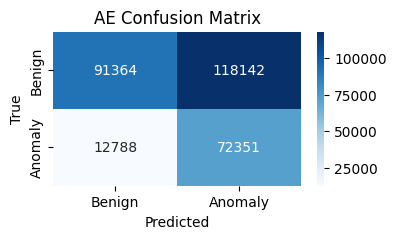


Quant AE Metrics:
True Positives (Anomalies correctly detected): 72351
True Negatives (Normal Traffic correctly identified): 91364
False Positives (Normal Traffic misclassified as Anomaly): 118142
False Negatives (Anomalies missed): 12788

Accuracy: 0.5556
Precision: 0.3798
Recall: 0.8498
F1 Score: 0.5250
False Positive Rate (FPR): 0.5639
False Negative Rate (FNR): 0.1502
Total number of Bots samples classified as malicious by AE: 324
Total number of Bots samples classified as benign by AE: 65


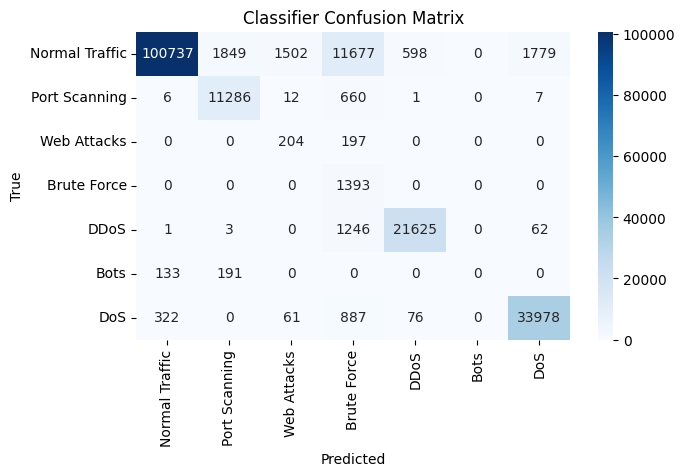

Total Malware Samples: 72351
Total Benign Samples: 118142

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 71889 (99.36% of Malware Identified)
True Negatives (Benign predicted as Benign): 100737 (85.27% of Benign Identified)
False Positives (Benign predicted as Malware): 17405 (14.73% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 462 (0.64% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 94.27%
Web Attacks: 50.87%
Brute Force: 100.00%
DDoS: 94.28%
Bots: 0.00%
DoS: 96.19%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9062
Precision (Malware): 0.8051
Recall / Sensitivity (Malware): 0.9936
F1-Score (Malware): 0.8895
False Positive Rate (Benign misclassified): 14.73%
False Negative Rate (Malware missed): 0.64%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 133


In [ ]:
# Evaluate Quant Models

# -----------------------------------
# --- Make Quant Models -------------
# -----------------------------------
ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8, mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8 = quant_models(autoencoder, classifier, y_classifier_train_no_Bots, X_classifier_train_no_Bots)

# -----------------------------------
# --- evaluate_weight_quant_model ---
# -----------------------------------

# List of TFLite models (AE + MLP)
tflite_weight_models = [
    {
        "ae_model": ae_quantModel_f32,
        "ae_name": "AE Float32 Model",
        "mlp_model": mlp_quantModel_f32,
        "mlp_name": "MLP Float32 Model"
    },
    {
        "ae_model": ae_quantModel_fp16_weights,
        "ae_name": "AE Float16 Weights-Only Model",
        "mlp_model": mlp_quantModel_fp16_weights,
        "mlp_name": "MLP Float16 Weights-Only Model"
    },
    {
        "ae_model": ae_quantModel_int8_weights,
        "ae_name": "AE Int8 Weights-Only Model",
        "mlp_model": mlp_quantModel_int8_weights,
        "mlp_name": "MLP Int8 Weights-Only Model"
    }
]

evaluate_weight_quant_model(tflite_weight_models,per_feature_thresholds, bots_encoding)

# --------------------------------------
# --- evaluate_full_int8_quant_model ---
# --------------------------------------

tflite_full_int_models = [
    {
        "ae_model": ae_quantModel_full_int8,
        "ae_name": "AE Full Int8 Quantized Model",
        "mlp_model": mlp_quantModel_full_int8,
        "mlp_name": "MLP Full Int8 Quantized Model"
    }
]

evaluate_full_int8_quant_model(tflite_full_int_models,bots_encoding)
